# Brief Overview

Auto ARIMA is a model which automatically sets the P,D,Q hyperparameters of the ARIMA model to return the most accurate model according to AIC/BIC values. Regular ARIMA is a linear time-series based model which accounts for a defined # previous values and errors. The "p" sets the number of previous terms, "q" sets the number of previous errors and "d" represents the # of times the data is differenced.

# Get Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import pmdarima as pm

# Create Functions

In [2]:
# Get Price/ Other Column attribute series for a specific ticker
def getStockSeries(data,measure,ticker):
    data = data[data['Name']==ticker].set_index('Date')
    return data[f"{measure}"]

# Plot ticker price or other measure
def plotStock(ticker,measure,tick_space):
    stock = df[df['Name'] == ticker]
    X = stock[f"{measure}"]
    y = stock['Date']
    plt.figure(figsize=(15,5))
    plt.plot(y,X)
    plt.xticks(stock['Date'][::tick_space])
    plt.show()
    
# Augmented Dickey-Fuller Test    
def adf(data,measure,ticker):
    adfResult = adfuller(data[f"{measure}"][data['Name']==ticker].dropna())
    if adfResult[1] < 0.05:
        print(f" Pvalue = {adfResult[1]}. data is stationary")
    else:
        print('non-stationary')

# Plot price data with forecast        
def plot_model(model,dataset,train,test):
    params = model.get_params()
    d = params['order'][1]
    
    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
    
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(dataset.index,dataset,label='data') 
    ax.plot(train.index[d:],train_pred,label='fitted')
    ax.plot(test.index,test_pred,label='forecast')
    ax.fill_between(test.index, \
                   confint[:,0],confint[:,1],\
                   color='red',alpha=0.3)
    ax.legend();
    
# Plot the model's forecast
def plot_forecast(model,test,Ntest):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)
    
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(test.index,test,label='actual')
    ax.plot(test.index,test_pred,label='forecast')
    ax.fill_between(test.index, \
                   confint[:,0],confint[:,1],\
                   color='red',alpha=0.3)
    ax.legend();

# Return the root mean squared error
def rmse(y,t):
    return np.sqrt(np.mean((t-y)**2))

# Get Data & Transform

In [3]:
df = pd.read_csv(r"C:\Users\Aaron\Data Udemy\sp500sub.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
1,2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2,2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
3,2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
4,2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


Open = Open price, High = Peak price, Low = Bottom price, Close = Closing Price

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225077 entries, 0 to 225076
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       225077 non-null  object 
 1   Open       225070 non-null  float64
 2   High       225070 non-null  float64
 3   Low        225070 non-null  float64
 4   Close      225070 non-null  float64
 5   Adj Close  225070 non-null  float64
 6   Volume     225070 non-null  float64
 7   Name       225077 non-null  object 
dtypes: float64(6), object(2)
memory usage: 13.7+ MB


In [6]:
# Convert Date to Date type
df['Date'] = pd.to_datetime(df['Date'])

# Get Log price
df['logPrice'] = np.log(df['Close'])

# Get log return
df['logReturn'] = df['logPrice'].groupby(df['Name']).diff()

The log price and log returns are statistically convenient ways of transforming price data to "improve" the forecasting accuracy. Stock prices are thought to follow a "random walk" which is a "log-normally distributed" and therefore taking the log will convert raw prices to "log prices" that follow a normal distribution. Then taking the difference (Yt-Y(t-1)) of log price results in log returns which conveniently gives us something that looks like a standard normal distribution with mean zero and unit variance.   

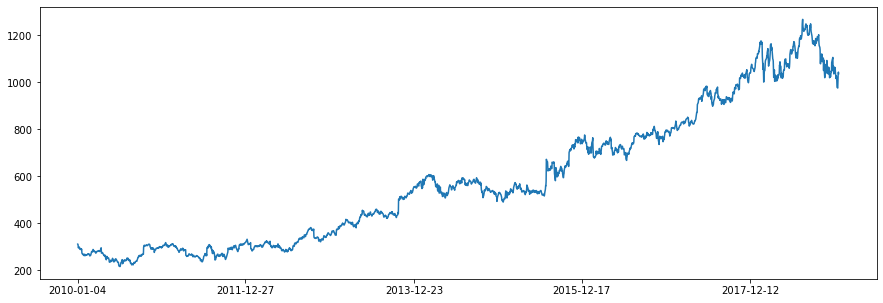

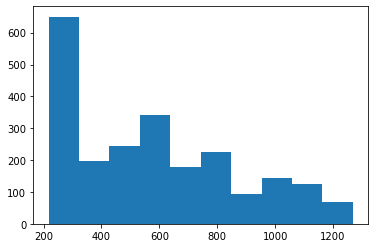

In [14]:
# Plot Raw Close Price
plotStock('GOOG','Close',500)

# Plot distribution of prices
plt.hist(getStockSeries(df,'Close','GOOG'));

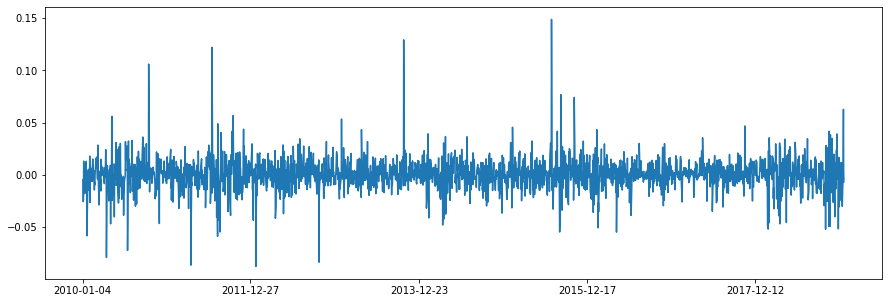

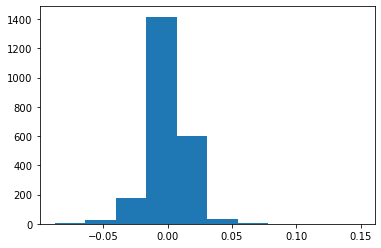

In [16]:
# Plot log returns
plotStock('GOOG','logReturn',500)

# Plot distribution of log returns
plt.hist(getStockSeries(df,'logReturn','GOOG'));

# Weak-Sense Stationarity

Thinking about the characteristics of a time-series graph can help explain why, when modeling, we might want to use transformations like the ones above. Time series data can display characteristics like trends and seasonality. This means when taking the mean of a time series, depending on what the period used is, the mean will return different values. The autocovariance will also differ depending on the chosen periods, and will result in a less accurate model. The opposite of this would be when the data has a constant mean and autocovariance aka it has "Weak-Sense Stationarity". Using the Augmented Dickey-Fuller Test we can check for stationarity. Without going too deep, it is a test where the null hypothesis is that the data is not stationary and given a 95% confidence interval if the p-value is 0.05 or lower then it has weak-sense stationarity and again has constant mean and autocovariance.

In [18]:
# Before transformations
adf(df,'Close','GOOG')

non-stationary


In [20]:
# After transformations - pvalue is so small that value just rounds to 0.
adf(df,'logReturn','GOOG')

 Pvalue = 0.0. data is stationary


# Autocorrelation & Partial Autocorrelation 

Autocorrelation refers to the correlation that a time series will have with itself based on discrete values determined by a given lag. A stationary dataset will have a constant zero autocorrelation. We use the acf plot to visualize this. lags on the x-axis, autocorrelation on the y. If the dots go outside the blue confidence bound we reject that the autocorrelation is 0.

Partial autocorrelation function is correlation that a time series will have with itself based on values between Yt --> Yt+lag-1. PA is conditioned on values within that lag space while autocorrelation only involves the two values Yt and Yt+lag-1. The pacf plot follows the same determining criteria as the acf.

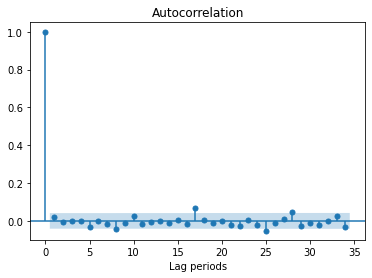

In [29]:
#Autocorrelation Function
plot_acf(getStockSeries(df,'logReturn','GOOG').dropna());
plt.xlabel('Lag periods')
plt.ylim(-.1, 1.05);

Value between 15 and 20 is slightly outside the confidence bounds, but if we consider the frequentist interpretation of 95% CI then we would expect a lag value to randomly be outside confidence bound 5% of the time. So we can conclude that there is 0 autocorrelation and again the data is stationary

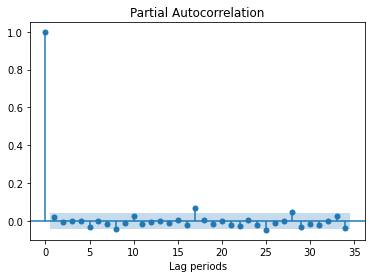

In [30]:
# Partial autocorrelation
plot_pacf(getStockSeries(df,'logReturn','GOOG').dropna(),method='ywm');
plt.xlabel('Lag periods')
plt.ylim(-.1, 1.05);

Without auto arima we would eyeball the acf and pacf to determine the q and p values respectively determined by the last value outside the CI on each plot. We ignore the 0 lag because the value will always correlate with itself, so the model built from this should have a p and q value of 0. Also again the d term represents the number of times the data set should be differenced for the best results. Since we will use logPrice to fit the model then it is expected that the data will be differenced once to get log return which will present those nice stationary characteristics. So our ARIMA(p,d,q) should result in a ARIMA(0,1,0).

# Prep Data for Model Training

In [49]:
Ntest = 30

# Get everything before the last 30 days for training
train = getStockSeries(df,'logPrice','GOOG')[:-Ntest].dropna()

#Get the last 30 days for model testing
test = getStockSeries(df,'logPrice','GOOG')[-Ntest:].dropna()

# Model fit

In [50]:
model = pm.auto_arima(train,
                    error_action='ignore',trace=True,
                    suppress_warnings=True, maxiter=10,
                    seaonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12337.862, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12345.190, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12344.278, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12344.280, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12344.408, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12342.305, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.582 seconds


It does appear that, as expected, our "best" model is the ARIMA(0,0,0). Again the auto arima model uses the AIC and BIC which stand for Akaike Information Criteria and Bayesian Information Criteria and is a way to penalize model complexity as defined by the number of parameters in the model. The more parsimonious model, ie. simple, the better given accuracy.  

# Predict/Plot Results

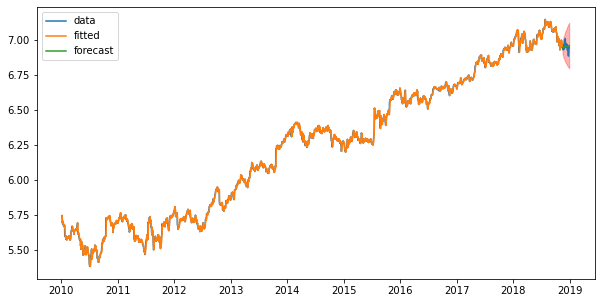

In [52]:
# Plot the data with forecast
dataset = getStockSeries(df,'logPrice','GOOG')
plot_model(model,dataset,train,test)

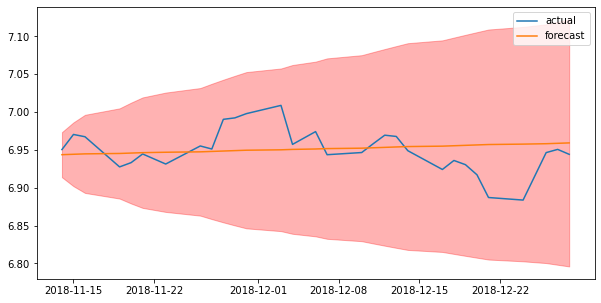

In [53]:
# Plot just forecast
plot_forecast(model,test,Ntest)

So the forecast from up close looks pretty bad, but at least the real data is within the confidence intervals.

In [56]:
# Get RMSE of model vs naive forecast

# Model Result
print(f"RMSE for model {rmse(model.predict(Ntest), test)}")

# Naive Result
print(f"RMSE for naive {rmse(train.iloc[-1],test)}")

RMSE for model 0.029999726943080327
RMSE for naive 0.028754567740846202


Comparing the auto arima best model to the naive forecast which just assumes the last value into the future, the naive forecast performs better.